# Import Necessary Libraries

In [96]:
#General Data Manipulation
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Data visualization library for plots and charts
import itertools  # Provides functions for efficient looping, used for complex iterations
import numpy as np  # Numerical operations, including array manipulation
import seaborn as sns  # Statistical data visualization, integrates well with pandas

#Natural Language Processing
import nltk  # Toolkit for working with human language data (text)
from nltk.corpus import stopwords, wordnet  # List of common stopwords for filtering out unimportant words
from nltk.stem import WordNetLemmatizer  # Lemmatization to reduce words to their base forms
from nltk import pos_tag
import spacy  # Industrial-strength NLP library for text processing
import re  # Regular expressions for filtering out emojis and numbers

#Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer  # Convert text to numeric features based on term importance
from sklearn.model_selection import cross_val_score  # Evaluate ML models using cross-validation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay  # Model evaluation metrics
from sklearn.pipeline import Pipeline  # Create pipelines for chaining ML tasks
from sklearn.compose import ColumnTransformer  # Helps to apply different preprocessing to different columns
from sklearn.preprocessing import OneHotEncoder  # Convert categorical variables into binary form (dummy variables)
from sklearn.model_selection import train_test_split  # Split data into training and testing sets
from sklearn.ensemble import RandomForestClassifier  # Random Forest classification algorithm
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classification algorithm
import tensorflow as tf  # TensorFlow for building and training neural networks

# Prepare Data for the model

In [97]:
#Import df and check loaded correctly
df_raw = pd.read_csv('final_hateXplain.csv')
df_raw.head()

,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,NaN
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive,No_race,Nonreligious,No_gender,No_orientation,Other
2,1 0 yrs <number> white women raped by niggers ...,hatespeech,African,Nonreligious,No_gender,No_orientation,NaN
3,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,NaN
4,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,NaN


In [98]:
#Check data integrity with data overview
df_raw.describe()

,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
count,20109,20109,20109,20109,20109,20109,3533
unique,20109,3,8,6,3,5,5
top,🤨 hm six million but yep they were disarmed ce...,normal,No_race,Nonreligious,No_gender,No_orientation,Other
freq,1,7818,13579,15387,16380,17827,2017


In [99]:
#Remove miscellaneous as missing ca. 17000 data points
df = df_raw.drop(['Miscellaneous'], axis=1)
df.columns #check Miscellaneous has dropped

Index(['comment', 'label', 'Race', 'Religion', 'Gender', 'Sexual Orientation'], dtype='object')

# Begin Natural Language Processing

## Start with tokenising 'comments' column to make it readable for algorithm

In [100]:
df['comment'] = df['comment'].apply(lambda x: nltk.word_tokenize(str(x))) #convert all to string and then tokenise as nltk expects strings
print(df['comment']) #check tokenised successfully

0                 [0, u0, lmao, wow, fuck, you, too, 😂, 😂]
1        [1, 0, th, floor, maybe, wow, cnn, with, the, ...
2        [1, 0, yrs, <, number, >, white, women, raped,...
3        [1, 2, h, ago, ching, chong, accepted, your, f...
4        [1, 8, th, century, mayhem, and, lawlessness, ...
                               ...                        
20104    [😂, 😂, 😂, 😂, 😂, y, ’, all, be, so, mad, at, ca...
20105    [🤔, 🤔, 🤔, 🤔, mmm, yes, the, trebuchet, memes, ...
20106    [🤣, this, so, ghetto, i, ’, m, ready, to, get,...
20107    [🤣, 🤣, 😂, 😂, 🤣, 🤣, 😂, 😂, 🤣, 🤣, you, spelled, m...
20108    [🤨, hm, six, million, but, yep, they, were, di...
Name: comment, Length: 20109, dtype: object


## Remove Stopwords, Emojis and Numbers (as they have neglible impact on hatespeech classification

In [101]:
# Download stopwords data
nltk.download('stopwords')

# Define the stopwords list
stop_words = set(stopwords.words('english'))

# Function to remove stopwords, emojis, and numbers
def clean_tokens(tokens):
    # Define a regex pattern to remove emojis. Leave u in for clarity to tell python it is unicode, even if obsolete in python3
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U00002600-\U000027BF"  # Misc symbols (more emojis)
                               "]+", flags=re.UNICODE)   # Not necessary to flag, but left in for clarity
   
    #Remove ordinal suffixes that have no meaning (in conjuction with isalpha)
    ordinal_suffixes = {"th", "st", "nd", "rd"}

    # Iterate over tokens to create cleaned_tokens that only include tokens that are lower case, not stopwords, emojis, digits, or empty
    cleaned_tokens = [token for token in tokens 
                      if token.lower() not in ordinal_suffixes  # Remove ordinal suffixes
                      and token.lower() not in stop_words  # Remove stopwords
                      and token.isalpha()  # Keep only alphabetic tokens (removes digits like 'th')
                      and not emoji_pattern.search(token)  # Remove emojis
                      and token.strip() != ""]  # Remove empty strings as offer no value to analysis
    return cleaned_tokens

#Print example to verify - should show only 'Hello'
example_tokens = ['   ', '🤣2133', 'th', 'Hello']
print(clean_tokens(example_tokens))

#Apply cleaning to comments column
df['comment'] = df['comment'].apply(lambda x:clean_tokens(x))
print(df['comment']) #Verify

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oliverlawrie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['Hello']
0                                        [lmao, wow, fuck]
1        [floor, maybe, wow, cnn, fakenews, body, count...
2        [yrs, number, white, women, raped, niggers, nu...
3        [h, ago, ching, chong, accepted, friend, request]
4        [century, mayhem, lawlessness, nothing, loud, ...
                               ...                        
20104    [mad, caucasians, failing, forget, blacks, sel...
20105    [mmm, yes, trebuchet, memes, much, nicer, cata...
20106                             [ghetto, ready, get, tf]
20107    [spelled, name, wrong, name, literally, front,...
20108    [hm, six, million, yep, disarmed, ceppin, ones...
Name: comment, Length: 20109, dtype: object


## Lemmatisation to reduce words to their dictionary form

In [102]:
# Download necessary packages for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to convert POS tags to WordNet format
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Define the lemmatizing function
def lemmatize_tokens(tokens_list):
    lemmatized_tokens = []
    pos_tags = pos_tag(tokens_list)  # Get POS tags for tokens

    for token, pos in pos_tags:
        wordnet_pos = get_wordnet_pos(pos)  # Convert POS to WordNet format
        lemmatized_token = lemmatizer.lemmatize(token.lower(), pos=wordnet_pos)  # Lemmatize based on POS
        lemmatized_tokens.append(lemmatized_token)

    return lemmatized_tokens

# Sample tokens for testing 
sample_tokens = ['Children', 'ruNning', 'cacti', 'bought']
print(lemmatize_tokens(sample_tokens))

['child', 'run', 'cactus', 'buy']


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oliverlawrie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/oliverlawrie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/oliverlawrie/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Apply lemmetization to the df

In [103]:
df['comment'] = df['comment'].apply(lambda x:lemmatize_tokens(x))
print(df['comment']) #Verify

0                                        [lmao, wow, fuck]
1        [floor, maybe, wow, cnn, fakenews, body, count...
2        [yrs, number, white, woman, rap, nigger, numbe...
3          [h, ago, ching, chong, accept, friend, request]
4        [century, mayhem, lawlessness, nothing, loud, ...
                               ...                        
20104       [mad, caucasian, fail, forget, black, sell, u]
20105    [mmm, yes, trebuchet, memes, much, nicer, cata...
20106                             [ghetto, ready, get, tf]
20107    [spell, name, wrong, name, literally, front, f...
20108    [hm, six, million, yep, disarm, ceppin, one, w...
Name: comment, Length: 20109, dtype: object


# Fit and Train Classification Model

In [104]:
# Define features and target
target = df['label'] #as we want to find out what kind of hate speech it is 
features = df.drop('label',axis=1) #all other features contribute to determinging 'label'

#Join comments back into strings as vectorisations expects string data type, and not tokens
features['comment'] = features['comment'].apply(lambda x: ' '.join(x))

#Preprocessing
preprocessing = ColumnTransformer(
     transformers=[
        ('tfidf', TfidfVectorizer(), 'comment'),  #Converts 'comment' column text into numerical values using Term Frequency-Inverse Document Frequency (Eg. More priority to universally common, but locally rare words)
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Race', 'Religion', 'Gender', 'Sexual Orientation'])  # One-Hot Encodes categorical variables into 1s and 0s for the model. #Ignore Unknown to avoid error message about bisexual not being a category trained on
    ]
)

#Create pipeline for model (as it keeps preprocessing and model training together in a single, repeatable process)
pipeline = Pipeline(steps=[ 
    ('preprocessing',preprocessing), #apply vectorisation and encoding as previously defined
    ('classifier',RandomForestClassifier(random_state=42)) #then fit data to random forest classifier model
])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [105]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'comment'),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Race', 'Religion', 'Gender',
                                                   'Sexual Orientation'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [106]:
# Make predictions
predictions = pipeline.predict(X_test)

In [110]:
# Function to compute metrics
def compute_metrics(y_true, predictions):
    cr = classification_report(y_true, predictions)
    print(cr)

    cm = confusion_matrix(y_true, predictions)
    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    confusion_matrix_display.plot()

              precision    recall  f1-score   support

  hatespeech       0.71      0.81      0.76      1325
      normal       0.77      0.82      0.80      1502
   offensive       0.61      0.46      0.53      1195

    accuracy                           0.71      4022
   macro avg       0.70      0.70      0.69      4022
weighted avg       0.70      0.71      0.70      4022



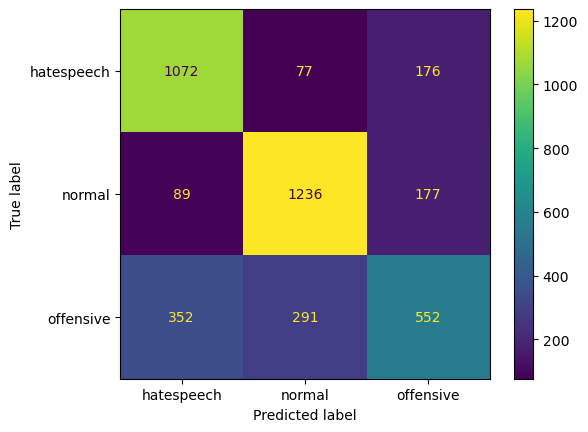

In [108]:
# Compute metrics for the test set
compute_metrics(y_test, predictions) #Precision = % True Positives, Recall = % of true samples of given, F1 Score is balance of both, support is just sum of a given category

#Precision for "Hatespeech": 75% of the samples predicted as "Hatespeech" were correct.
#Recall for "Hatespeech": The model caught 60% of the true "Hatespeech" instances.
#F1-score: The overall balance between precision and recall for "Hatespeech" is 0.67.
#Support: There were 150 actual "Hatespeech" samples in the test set.

In [1]:
# Perform cross-validation
score = cross_val_score(pipeline, features, target, cv=3)

print(score)

#This means that in three different splits of the data:

#Fold 1 accuracy: 78%
#Fold 2 accuracy: 76%
#Fold 3 accuracy: 79%

NameError: name 'cross_val_score' is not defined

## Optimisations

Certain words get lemmatised erroneously, eg raped becomes rap.
Why did I choose RFC model?
Advantages of using pipeline?
Check what recall scores etc. actually means...